In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
torch.manual_seed(42)
np.random.seed(42)

# Exercise 01

<span style="font-size: 15px;">In this exercise, we will prepare data for training a diffusion model. Diffusion models learn to generate images by iteratively denoising random noise into structured data. Before we can train such a model, we need:

1. **A dataset of images**: We will generate synthetic images of polynomial plots
2. **A data pipeline**: Convert images to tensors and load them efficiently in batches
3. **Visualization tools**: Verify our pipeline by converting tensors back to images

This notebook demonstrates the complete data preparation workflow:

| Step | Description | Output |
|------|-------------|--------|
| **Section 1** | Generate polynomial plots | 500 PNG images in `./data/` |
| **Section 2** | Load and convert to tensors | DataLoader with batches of 16 |
| **Visualization** | Tensor → Image function | Verify data integrity |

Throughout this notebook:
- $N$ denotes the total number of samples (500 polynomial plots)
- $B$ denotes the batch size (16)
- $C$, $H$, $W$ denote channels (3 for RGB), height, and width of images

</span>

<span style="font-size: 15px;">

In this exercise, we prepare a custom dataset for diffusion model training. We will:

1. Generate polynomial plots with random degrees and coefficients
2. Save them as images
3. Load them into a PyTorch DataLoader
4. Create utility functions to visualize the data

This workflow mirrors real-world scenarios where we need to create custom datasets from scratch.

</span>

## Section 1: Creating Data as Plots

<span style="font-size: 15px;">

We generate synthetic training data by creating plots of random polynomials. Each polynomial has:

- **Random degree**: $d \in \{1, 2, 3, 4, 5\}$
- **Random coefficients**: $a_i \sim \mathcal{U}(-2, 2)$ for $i = 0, 1, ..., d$

A polynomial of degree $d$ is defined as:

$$
p(x) = a_d x^d + a_{d-1} x^{d-1} + ... + a_1 x + a_0
$$

We generate 500 such polynomials, plot each one using matplotlib, and save the plots as PNG images.

</span>

In [2]:
def generate_random_polynomial():
    """Generate a random polynomial with random degree and coefficients.
    
    Returns:
        coefficients: numpy array of coefficients [a_0, a_1, ..., a_d]
        degree: int, the degree of the polynomial
    """
    # Random degree between 1 and 5
    degree = np.random.randint(1, 6)
    
    # Random coefficients uniformly distributed in [-2, 2]
    coefficients = np.random.uniform(-2, 2, size=degree + 1)
    
    return coefficients, degree


def evaluate_polynomial(coefficients, x):
    """Evaluate polynomial at given x values.
    
    Args:
        coefficients: array of coefficients [a_0, a_1, ..., a_d]
        x: array of x values to evaluate at
    
    Returns:
        y: array of polynomial values p(x)
    """
    # np.polyval expects coefficients in descending order [a_d, ..., a_1, a_0]
    return np.polyval(coefficients[::-1], x)


# Test the functions
coeffs, deg = generate_random_polynomial()
print(f"Generated polynomial of degree {deg}")
print(f"Coefficients (a_0 to a_{deg}): {coeffs}")

x_test = np.linspace(-2, 2, 5)
y_test = evaluate_polynomial(coeffs, x_test)
print(f"\nSample evaluations:")
for xi, yi in zip(x_test, y_test):
    print(f"  p({xi:.1f}) = {yi:.3f}")

Generated polynomial of degree 4
Coefficients (a_0 to a_4): [ 1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192]

Sample evaluations:
  p(-2.0) = -9.484
  p(-1.0) = 1.269
  p(0.0) = 1.803
  p(1.0) = 0.374
  p(2.0) = -27.786


Test plot saved as 'test_polynomial.png'


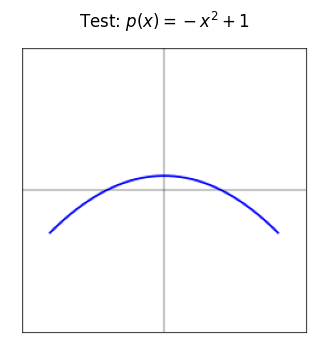

In [3]:
def plot_polynomial(coefficients, save_path, figsize=(4, 4), dpi=64):
    """Plot a polynomial and save it as an image.
    
    Args:
        coefficients: array of coefficients [a_0, a_1, ..., a_d]
        save_path: path to save the image
        figsize: figure size in inches (default: 4x4)
        dpi: dots per inch (default: 64, resulting in 256x256 pixel images)
    """
    # Create x values
    x = np.linspace(-2, 2, 200)
    y = evaluate_polynomial(coefficients, x)
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Plot the polynomial
    ax.plot(x, y, 'b-', linewidth=2)
    
    # Set consistent axis limits
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-10, 10)
    
    # Add grid for visual structure
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linewidth=0.5)
    ax.axvline(x=0, color='k', linewidth=0.5)
    
    # Remove axis labels and ticks for cleaner images
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Save and close
    plt.tight_layout()
    plt.savefig(save_path, facecolor='white', edgecolor='none')
    plt.close(fig)


# Test: Plot a single polynomial
test_coeffs = [1, 0, -1]  # p(x) = -x^2 + 1 (parabola opening downward)
plot_polynomial(test_coeffs, 'test_polynomial.png')
print("Test plot saved as 'test_polynomial.png'")

# Display the test plot
test_img = Image.open('test_polynomial.png')
plt.figure(figsize=(4, 4))
plt.imshow(test_img)
plt.title('Test: $p(x) = -x^2 + 1$')
plt.axis('off')
plt.show()

# Clean up test file
os.remove('test_polynomial.png')

In [4]:
def generate_polynomial_dataset(n_samples, data_dir='./data'):
    """Generate a dataset of polynomial plots.
    
    Args:
        n_samples: number of polynomial plots to generate
        data_dir: directory to save the images
    
    Returns:
        metadata: list of dicts containing info about each polynomial
    """
    # Create data directory if it doesn't exist
    os.makedirs(data_dir, exist_ok=True)
    
    metadata = []
    
    print(f"Generating {n_samples} polynomial plots...")
    
    for i in range(n_samples):
        # Generate random polynomial
        coeffs, degree = generate_random_polynomial()
        
        # Save path: data/0.png, data/1.png, ...
        save_path = os.path.join(data_dir, f"{i}.png")
        
        # Plot and save
        plot_polynomial(coeffs, save_path)
        
        # Store metadata
        metadata.append({
            'index': i,
            'degree': degree,
            'coefficients': coeffs.tolist(),
            'path': save_path
        })
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{n_samples} plots")
    
    print(f"Done! Saved {n_samples} images to '{data_dir}/'")
    return metadata

In [5]:
# Generate the dataset
N_SAMPLES = 500
DATA_DIR = './data'

metadata = generate_polynomial_dataset(N_SAMPLES, DATA_DIR)

Generating 500 polynomial plots...
  Generated 100/500 plots
  Generated 200/500 plots
  Generated 300/500 plots
  Generated 400/500 plots
  Generated 500/500 plots
Done! Saved 500 images to './data/'


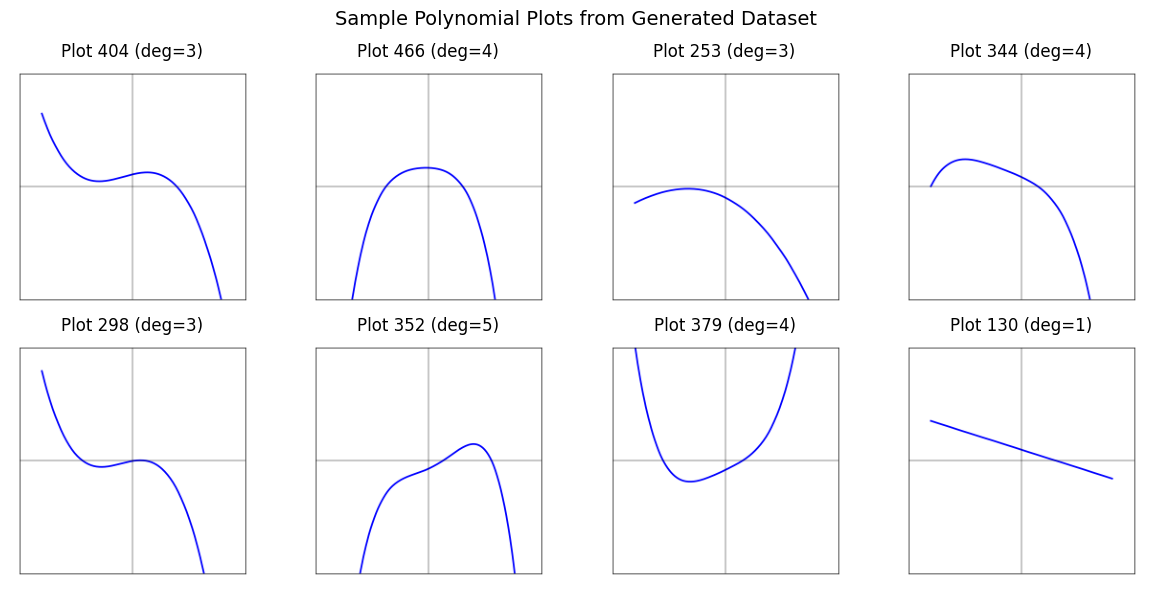


Dataset Statistics:
  Total samples: 500
  Degree distribution:
    Degree 1: 109 samples (21.8%)
    Degree 2: 96 samples (19.2%)
    Degree 3: 88 samples (17.6%)
    Degree 4: 94 samples (18.8%)
    Degree 5: 113 samples (22.6%)


In [6]:
# Visualize some generated samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Select 8 random samples to display
sample_indices = np.random.choice(N_SAMPLES, 8, replace=False)

for ax, idx in zip(axes, sample_indices):
    img_path = os.path.join(DATA_DIR, f"{idx}.png")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Plot {idx} (deg={metadata[idx]['degree']})")
    ax.axis('off')

plt.suptitle('Sample Polynomial Plots from Generated Dataset', fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics
degrees = [m['degree'] for m in metadata]
print(f"\nDataset Statistics:")
print(f"  Total samples: {len(metadata)}")
print(f"  Degree distribution:")
for d in range(1, 6):
    count = degrees.count(d)
    print(f"    Degree {d}: {count} samples ({100*count/len(metadata):.1f}%)")

## Section 2: Converting Plots to Tensors

<span style="font-size: 15px;">

Now we need to load the generated images and convert them to PyTorch tensors for training. This involves:

1. **Creating a custom Dataset class**: Implements `__len__` and `__getitem__` methods
2. **Applying transforms**: Resize images to uniform size, convert to tensors, normalize
3. **Creating a DataLoader**: Batch the data and enable shuffling

For diffusion models, images are typically normalized to the range $[-1, 1]$:

$$
x_{\text{normalized}} = 2 \cdot \frac{x - x_{\min}}{x_{\max} - x_{\min}} - 1
$$

This normalization is important because diffusion models add Gaussian noise (which has mean 0) to the images.

</span>

In [7]:
# First, let's define our transform classes (following the pattern from the reference notebook)

class Compose:
    """Compose multiple transforms together.
    
    Args:
        transforms: List of transforms to compose
    """
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, x):
        for transform in self.transforms:
            x = transform(x)
        return x
    
    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += f'\n    {t},'
        format_string += '\n)'
        return format_string


class ToTensor:
    """Convert PIL Image or numpy array to PyTorch tensor.
    
    Converts image from (H, W, C) with values [0, 255] 
    to (C, H, W) with values [0.0, 1.0].
    """
    def __call__(self, x):
        if isinstance(x, Image.Image):
            x = np.array(x)
        
        if isinstance(x, np.ndarray):
            # Handle image data: (H, W, C) -> (C, H, W)
            if x.ndim == 3:
                x = x.transpose(2, 0, 1)
            # Normalize to [0, 1]
            x = x.astype(np.float32) / 255.0
            return torch.from_numpy(x)
        return x
    
    def __repr__(self):
        return "ToTensor()"


class Resize:
    """Resize image to given size.
    
    Args:
        size: Target size (H, W) or single int for square
    """
    def __init__(self, size):
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size
    
    def __call__(self, x):
        if isinstance(x, Image.Image):
            return x.resize((self.size[1], self.size[0]), Image.Resampling.BILINEAR)
        return x
    
    def __repr__(self):
        return f"Resize(size={self.size})"


class NormalizeMinusOneToOne:
    """Normalize tensor from [0, 1] to [-1, 1].
    
    This normalization is commonly used for diffusion models:
        x_normalized = 2 * x - 1
    """
    def __call__(self, x):
        return 2.0 * x - 1.0
    
    def __repr__(self):
        return "NormalizeMinusOneToOne()"


# Test the transforms
print("Testing transforms:")
test_img = Image.open(os.path.join(DATA_DIR, '0.png'))
print(f"Original image: {test_img.size} (W, H), mode={test_img.mode}")

resize = Resize(64)
resized = resize(test_img)
print(f"After Resize(64): {resized.size}")

to_tensor = ToTensor()
tensor = to_tensor(resized)
print(f"After ToTensor: shape={tensor.shape}, range=[{tensor.min():.3f}, {tensor.max():.3f}]")

normalize = NormalizeMinusOneToOne()
normalized = normalize(tensor)
print(f"After NormalizeMinusOneToOne: range=[{normalized.min():.3f}, {normalized.max():.3f}]")

Testing transforms:
Original image: (256, 256) (W, H), mode=RGBA
After Resize(64): (64, 64)
After ToTensor: shape=torch.Size([4, 64, 64]), range=[0.533, 1.000]
After NormalizeMinusOneToOne: range=[0.067, 1.000]


In [8]:
class PolynomialPlotDataset(Dataset):
    """Dataset for polynomial plot images.
    
    Args:
        data_dir: Directory containing the PNG images
        transform: Optional transform to apply to images
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Get list of all PNG files in the directory
        self.image_files = sorted(
            [f for f in os.listdir(data_dir) if f.endswith('.png')],
            key=lambda x: int(x.split('.')[0])  # Sort by numeric index
        )
        
        print(f"Found {len(self.image_files)} images in '{data_dir}'")
    
    def __len__(self):
        """Return the total number of samples."""
        return len(self.image_files)
    
    def __getitem__(self, idx):
        """Return the sample at the given index.
        
        Args:
            idx: Index of the sample
        
        Returns:
            tensor: Image tensor of shape (C, H, W)
        """
        # Load image
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        
        # Apply transforms if provided
        if self.transform is not None:
            image = self.transform(image)
        
        return image
    
    def __repr__(self):
        return f"PolynomialPlotDataset(n_samples={len(self)}, data_dir='{self.data_dir}')"

In [15]:
# Define the image size (all images will be resized to this)
IMAGE_SIZE = 250  # 250x250 pixels

# Create the transform pipeline
transform = Compose([
    Resize(IMAGE_SIZE),           # Resize to uniform size
    ToTensor(),                   # Convert to tensor, scale to [0, 1]
    NormalizeMinusOneToOne(),     # Scale to [-1, 1] for diffusion
])

print("Transform pipeline:")
print(transform)

Transform pipeline:
Compose(
    Resize(size=(250, 250)),
    ToTensor(),
    NormalizeMinusOneToOne(),
)


In [16]:
# Create the dataset
dataset = PolynomialPlotDataset(DATA_DIR, transform=transform)
print(f"\nDataset: {dataset}")
print(f"Number of samples: {len(dataset)}")

# Test accessing a single sample
sample = dataset[0]
print(f"\nSample tensor:")
print(f"  Shape: {sample.shape}")
print(f"  Dtype: {sample.dtype}")
print(f"  Range: [{sample.min():.3f}, {sample.max():.3f}]")

Found 500 images in './data'

Dataset: PolynomialPlotDataset(n_samples=500, data_dir='./data')
Number of samples: 500

Sample tensor:
  Shape: torch.Size([3, 250, 250])
  Dtype: torch.float32
  Range: [-0.976, 1.000]


In [17]:
# Create the DataLoader
BATCH_SIZE = 16

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Shuffle for training
    num_workers=0,     # Use 0 for compatibility; increase in production
    drop_last=True     # Drop incomplete last batch for consistent batch size
)

print(f"DataLoader created with batch_size={BATCH_SIZE}")
print(f"Number of batches: {len(dataloader)}")
print(f"Total samples that will be used: {len(dataloader) * BATCH_SIZE}")

DataLoader created with batch_size=16
Number of batches: 31
Total samples that will be used: 496


In [18]:
# Test iterating through the DataLoader
print("Testing DataLoader iteration:")
print("-" * 40)

for batch_idx, batch in enumerate(dataloader):
    print(f"Batch {batch_idx}: shape={batch.shape}, dtype={batch.dtype}")
    
    # Only print first 3 batches
    if batch_idx >= 2:
        print("...")
        break

# Get one batch for demonstration
sample_batch = next(iter(dataloader))
print(f"\nSample batch details:")
print(f"  Shape: {sample_batch.shape} (B, C, H, W)")
print(f"  Batch size (B): {sample_batch.shape[0]}")
print(f"  Channels (C): {sample_batch.shape[1]}")
print(f"  Height (H): {sample_batch.shape[2]}")
print(f"  Width (W): {sample_batch.shape[3]}")
print(f"  Memory: {sample_batch.element_size() * sample_batch.numel() / 1024:.2f} KB")

Testing DataLoader iteration:
----------------------------------------
Batch 0: shape=torch.Size([16, 3, 250, 250]), dtype=torch.float32
Batch 1: shape=torch.Size([16, 3, 250, 250]), dtype=torch.float32
Batch 2: shape=torch.Size([16, 3, 250, 250]), dtype=torch.float32
...

Sample batch details:
  Shape: torch.Size([16, 3, 250, 250]) (B, C, H, W)
  Batch size (B): 16
  Channels (C): 3
  Height (H): 250
  Width (W): 250
  Memory: 11718.75 KB


<span style="font-size: 15px;">

### Tensor to Image Visualization Function

To verify our data pipeline is working correctly, we need a function that can convert tensors back to displayable images. This is the inverse of our transform pipeline:

1. **Denormalize**: Convert from $[-1, 1]$ back to $[0, 1]$: $x = \frac{x_{\text{normalized}} + 1}{2}$
2. **Rearrange dimensions**: From $(C, H, W)$ to $(H, W, C)$
3. **Convert to numpy**: For matplotlib display

</span>

In [19]:
def tensor_to_image(tensor):
    """Convert a tensor from the DataLoader back to a displayable image.
    
    This function reverses the transforms applied during data loading:
    1. Denormalize from [-1, 1] to [0, 1]
    2. Rearrange from (C, H, W) to (H, W, C)
    3. Convert to numpy array
    4. Clip values to valid range
    
    Args:
        tensor: PyTorch tensor of shape (C, H, W) with values in [-1, 1]
    
    Returns:
        numpy array of shape (H, W, C) with values in [0, 1], suitable for plt.imshow()
    """
    # Handle batched tensors by taking the first image
    if tensor.dim() == 4:
        tensor = tensor[0]
    
    # Clone to avoid modifying the original tensor
    img = tensor.clone()
    
    # Denormalize: [-1, 1] -> [0, 1]
    img = (img + 1.0) / 2.0
    
    # Rearrange dimensions: (C, H, W) -> (H, W, C)
    img = img.permute(1, 2, 0)
    
    # Convert to numpy
    img = img.numpy()
    
    # Clip to valid range [0, 1] (in case of numerical errors)
    img = np.clip(img, 0, 1)
    
    return img


def plot_tensor(tensor, title=None):
    """Plot a single tensor as an image.
    
    Args:
        tensor: PyTorch tensor of shape (C, H, W) or (B, C, H, W)
        title: Optional title for the plot
    """
    img = tensor_to_image(tensor)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


def plot_batch(batch, n_cols=4, figsize=(12, 12)):
    """Plot a batch of tensors as a grid of images.
    
    Args:
        batch: PyTorch tensor of shape (B, C, H, W)
        n_cols: Number of columns in the grid
        figsize: Figure size
    """
    batch_size = batch.shape[0]
    n_rows = (batch_size + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if batch_size > 1 else [axes]
    
    for idx, ax in enumerate(axes):
        if idx < batch_size:
            img = tensor_to_image(batch[idx])
            ax.imshow(img)
            ax.set_title(f'Sample {idx}')
        ax.axis('off')
    
    plt.suptitle(f'Batch of {batch_size} Images (Reconstructed from Tensors)', fontsize=14)
    plt.tight_layout()
    plt.show()

Testing tensor_to_image function:
----------------------------------------
Input tensor: shape=torch.Size([3, 250, 250]), range=[-0.929, 1.000]
Output image: shape=(250, 250, 3), range=[0.035, 1.000]


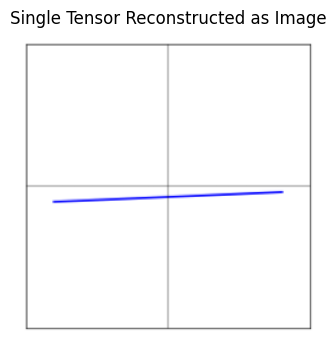

In [20]:
# Test the tensor_to_image function with a single sample
print("Testing tensor_to_image function:")
print("-" * 40)

# Get a sample from the dataset
sample_tensor = dataset[42]
print(f"Input tensor: shape={sample_tensor.shape}, range=[{sample_tensor.min():.3f}, {sample_tensor.max():.3f}]")

# Convert back to image
reconstructed_img = tensor_to_image(sample_tensor)
print(f"Output image: shape={reconstructed_img.shape}, range=[{reconstructed_img.min():.3f}, {reconstructed_img.max():.3f}]")

# Plot single tensor
plot_tensor(sample_tensor, title='Single Tensor Reconstructed as Image')

Testing with a batch from DataLoader:
----------------------------------------
Batch shape: torch.Size([16, 3, 250, 250])
Batch range: [-0.976, 1.000]


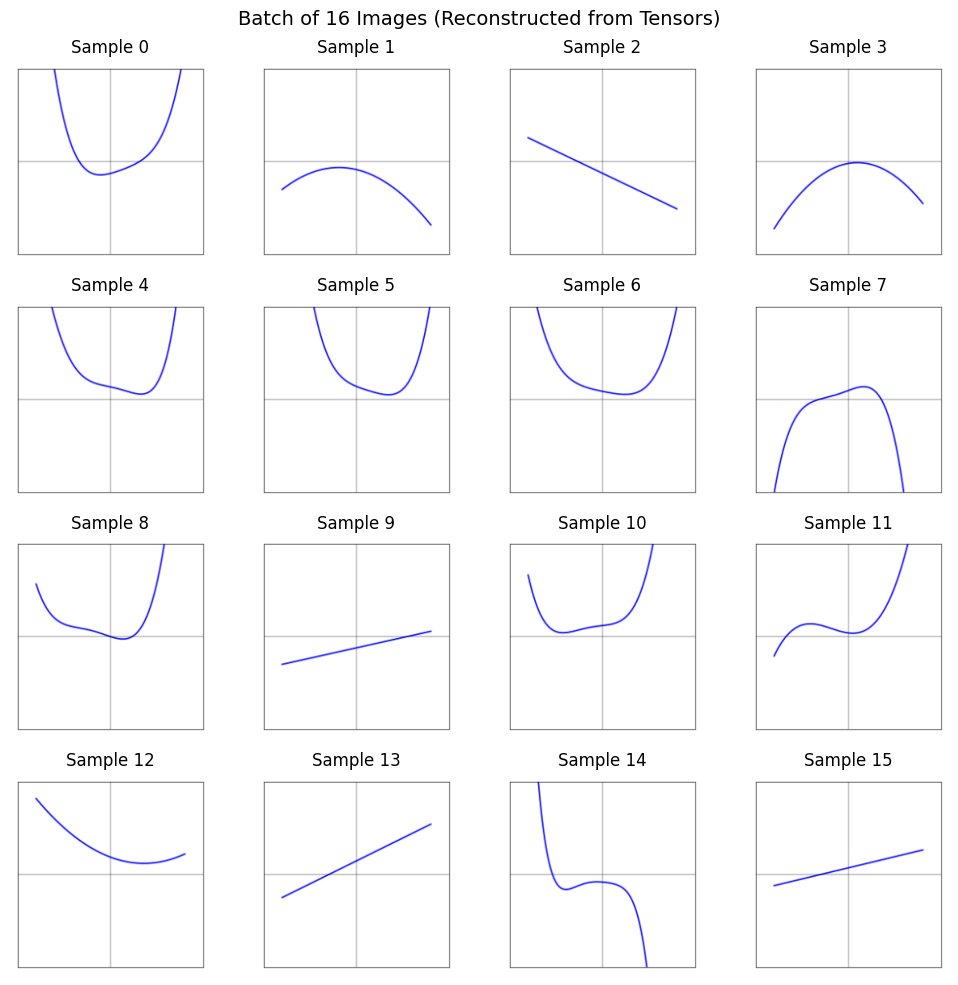

In [21]:
# Test with a full batch from the DataLoader
print("Testing with a batch from DataLoader:")
print("-" * 40)

# Get a batch
batch = next(iter(dataloader))
print(f"Batch shape: {batch.shape}")
print(f"Batch range: [{batch.min():.3f}, {batch.max():.3f}]")

# Plot the entire batch
plot_batch(batch, n_cols=4, figsize=(10, 10))

Pipeline Verification: Original vs Reconstructed


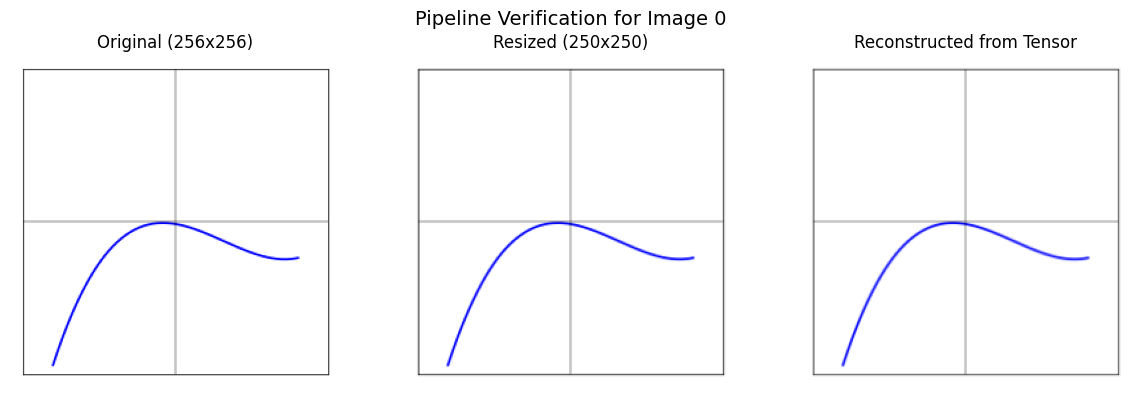

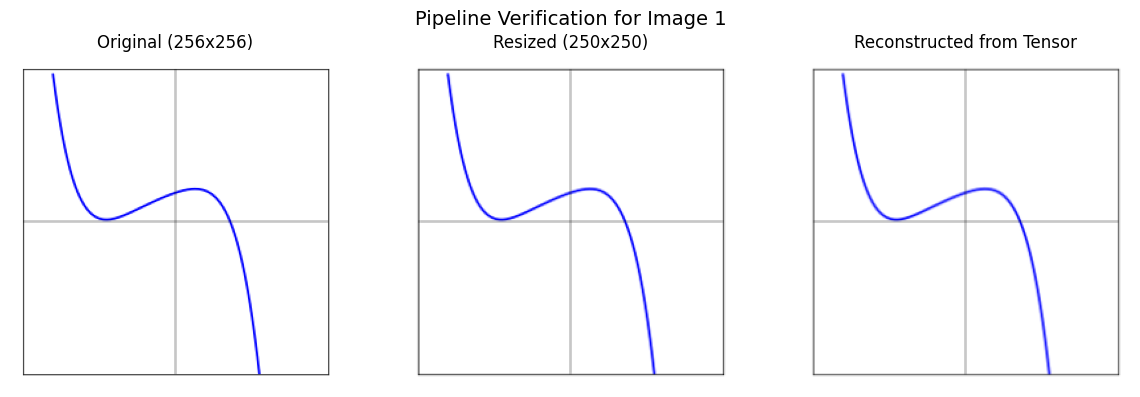

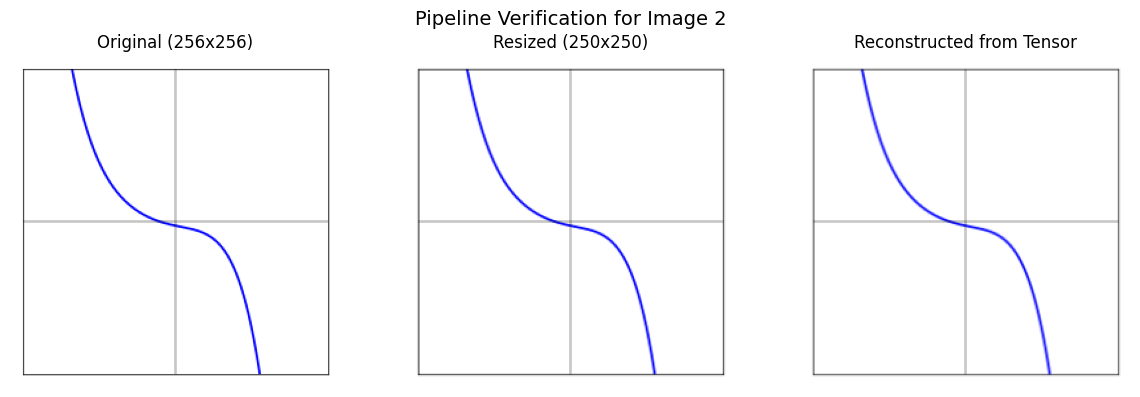

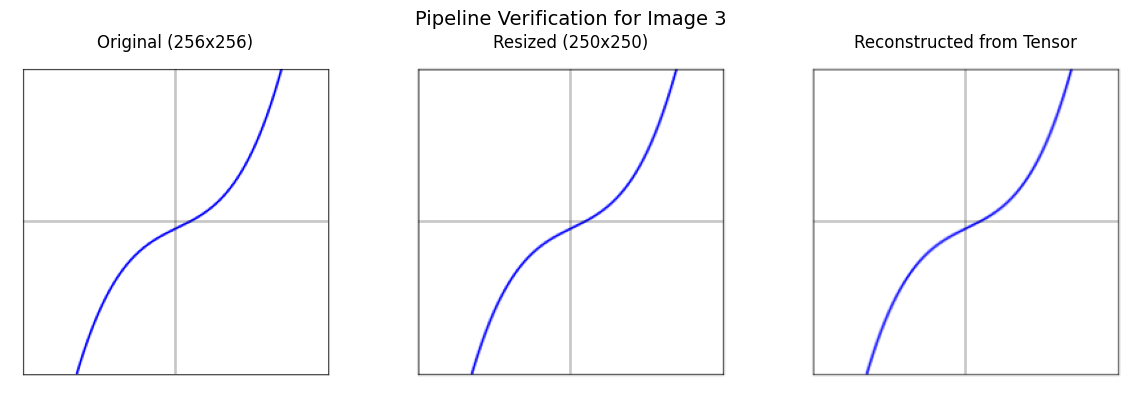

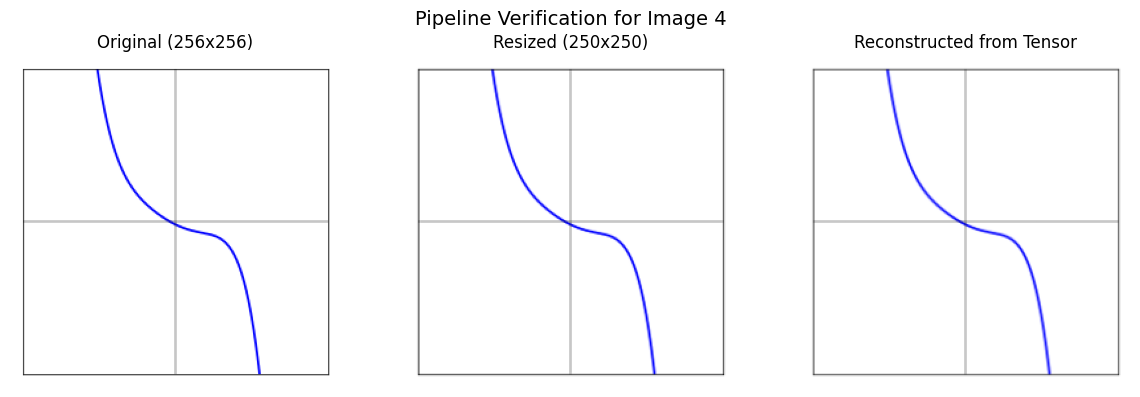


✓ Pipeline verification complete!
  Original image loaded from: ./data/4.png
  Tensor shape: torch.Size([3, 250, 250])
  Reconstructed image shape: (250, 250, 3)


In [23]:
# Verify the complete pipeline: Original -> Tensor -> Reconstructed
print("Pipeline Verification: Original vs Reconstructed")
print("=" * 50)

for i in range(5):
    test_idx = i
    # Load original image directly
    original_path = os.path.join(DATA_DIR, f"{test_idx}.png")
    original_img = Image.open(original_path).convert('RGB')
    original_img_resized = original_img.resize((IMAGE_SIZE, IMAGE_SIZE))
    # Get tensor from dataset and convert back
    tensor_from_dataset = dataset[test_idx]
    reconstructed = tensor_to_image(tensor_from_dataset)
    # Display side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original ({original_img.size[0]}x{original_img.size[1]})')
    axes[0].axis('off')

    axes[1].imshow(original_img_resized)
    axes[1].set_title(f'Resized ({IMAGE_SIZE}x{IMAGE_SIZE})')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed from Tensor')
    axes[2].axis('off')

    plt.suptitle(f'Pipeline Verification for Image {test_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

print(f"\n✓ Pipeline verification complete!")
print(f"  Original image loaded from: {original_path}")
print(f"  Tensor shape: {tensor_from_dataset.shape}")
print(f"  Reconstructed image shape: {reconstructed.shape}")

## Section 3: Training a Diffusion Model to Generate Polynomial Plots

<span style="font-size: 15px;">

In this section, we will implement a **complete diffusion model** from scratch and train it to generate images of polynomial plots. By the end, our model will be able to start from **pure random noise** and iteratively denoise it into coherent polynomial plot images.

**Prerequisites**: This section assumes we have already run the data preparation notebook, which:
- Generated 500 polynomial plot images saved in `./data/`
- Created a `PolynomialPlotDataset` class and `DataLoader` with batch size 16
- Defined the `tensor_to_image()` function for visualization

**What We'll Build:**

| Component | Description |
|-----------|-------------|
| **Noise Schedule** | The $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$ values that control noise levels |
| **Forward Diffusion** | Adding noise to images: $x_0 \to x_t$ |
| **U-Net Architecture** | Neural network $\epsilon_\theta(x_t, t)$ that predicts noise |
| **Training Loop** | Learning to predict the noise that was added |
| **Sampling Algorithm** | Generating new images from pure noise: $x_T \to x_0$ |

</span>

### The Core Idea: Learning to Denoise

<span style="font-size: 15px;">

Diffusion models work by learning to **reverse a gradual noising process**. The key insight is:

> If we systematically destroy data by adding noise step by step, we can train a neural network to reverse each step. Then, starting from pure noise, we can generate new data by applying this learned reversal.

**The Two Processes:**

**1. Forward Process (Destroying Data)** — Fixed, not learned
$$x_0 \xrightarrow{+\text{noise}} x_1 \xrightarrow{+\text{noise}} \cdots \xrightarrow{+\text{noise}} x_T \sim \mathcal{N}(0, I)$$

**2. Reverse Process (Creating Data)** — Learned by neural network
$$x_T \xrightarrow{-\text{noise}} x_{T-1} \xrightarrow{-\text{noise}} \cdots \xrightarrow{-\text{noise}} x_0$$

**Notation We'll Use:**

| Symbol | Meaning |
|--------|--------|
| $x_0$ | Clean image from our dataset |
| $x_t$ | Noisy image at timestep $t$ |
| $T$ | Total number of timesteps (e.g., 1000) |
| $\epsilon$ | Pure Gaussian noise $\sim \mathcal{N}(0, I)$ |
| $\epsilon_\theta(x_t, t)$ | Neural network predicting the noise in $x_t$ |
| $\beta_t$ | Variance schedule at step $t$ |
| $\alpha_t$ | $1 - \beta_t$ |
| $\bar{\alpha}_t$ | $\prod_{i=1}^{t} \alpha_i$ (cumulative product) |

</span>

In [25]:
# Device configuration
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using device: {device}")

Using device: mps


### Loading the Dataset (From Previous Notebook)

<span style="font-size: 15px;">

We'll recreate the dataset and dataloader from the previous notebook. The images are normalized to $[-1, 1]$, which is standard for diffusion models since the noise $\epsilon \sim \mathcal{N}(0, I)$ also lives in this range.

</span>

In [26]:
# ============================================================
# Dataset and DataLoader (from previous notebook)
# ============================================================

DATA_DIR = './data'
IMAGE_SIZE = 64  # We'll use 64x64 for faster training
BATCH_SIZE = 16

class Compose:
    """Chain multiple transforms together."""
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x

class Resize:
    """Resize image to target size."""
    def __init__(self, size):
        self.size = (size, size) if isinstance(size, int) else size
    
    def __call__(self, img):
        return img.resize(self.size, Image.BILINEAR)

class ToTensor:
    """Convert PIL Image to tensor and scale to [0, 1]."""
    def __call__(self, img):
        img_array = np.array(img).astype(np.float32) / 255.0
        tensor = torch.from_numpy(img_array)
        return tensor.permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

class NormalizeMinusOneToOne:
    """Normalize from [0, 1] to [-1, 1]."""
    def __call__(self, x):
        return 2.0 * x - 1.0

class PolynomialPlotDataset(Dataset):
    """Dataset for polynomial plot images."""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted(
            [f for f in os.listdir(data_dir) if f.endswith('.png')],
            key=lambda x: int(x.split('.')[0])
        )
        print(f"Found {len(self.image_files)} images in '{data_dir}'")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Create transform pipeline
transform = Compose([
    Resize(IMAGE_SIZE),
    ToTensor(),
    NormalizeMinusOneToOne(),
])

# Create dataset and dataloader
dataset = PolynomialPlotDataset(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")
print(f"Image shape: {dataset[0].shape}")

Found 500 images in './data'
Dataset size: 500
Number of batches: 31
Image shape: torch.Size([3, 64, 64])


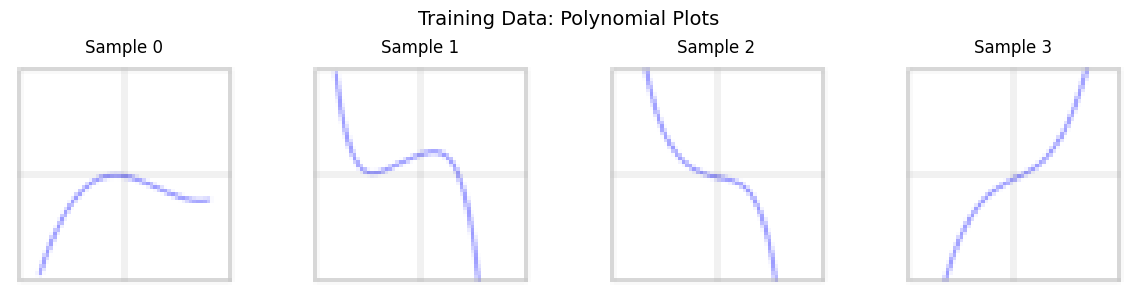

In [27]:
def tensor_to_image(tensor):
    """Convert tensor from [-1, 1] back to displayable image."""
    if tensor.dim() == 4:
        tensor = tensor[0]
    img = tensor.clone().detach().cpu()
    img = (img + 1.0) / 2.0  # [-1, 1] -> [0, 1]
    img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = torch.clamp(img, 0, 1)
    return img.numpy()

# Visualize a few samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(tensor_to_image(dataset[i]))
    ax.set_title(f'Sample {i}')
    ax.axis('off')
plt.suptitle('Training Data: Polynomial Plots', fontsize=14)
plt.tight_layout()
plt.show()

### Part 1: The Noise Schedule

<span style="font-size: 15px;">

The **noise schedule** defines how much noise is added at each timestep. It's characterized by the sequence $\beta_1, \beta_2, \ldots, \beta_T$.

**Key Variables:**

$$
\begin{align}
\beta_t &\in (0, 1) \quad \text{(variance at step } t \text{, typically small)} \\
\alpha_t &= 1 - \beta_t \\
\bar{\alpha}_t &= \prod_{i=1}^{t} \alpha_i = \alpha_1 \cdot \alpha_2 \cdots \alpha_t
\end{align}
$$

**Common Schedule Types:**

| Schedule | Formula | Characteristics |
|----------|---------|----------------|
| **Linear** | $\beta_t = \beta_{\min} + \frac{t-1}{T-1}(\beta_{\max} - \beta_{\min})$ | Simple, works well |
| **Cosine** | Based on $\bar{\alpha}_t = \frac{f(t)}{f(0)}$ where $f(t) = \cos^2(\cdot)$ | Smoother transitions |

We'll use a **linear schedule** from $\beta_1 = 0.0001$ to $\beta_T = 0.02$.

</span>

In [28]:
class NoiseSchedule:
    """
    Defines the noise schedule for the diffusion process.
    
    The schedule determines:
    - βₜ: How much noise to add at each step
    - αₜ = 1 - βₜ: How much signal to keep
    - ᾱₜ = ∏αᵢ: Cumulative signal remaining
    """
    
    def __init__(self, T=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        """
        Args:
            T: Total number of timesteps
            beta_start: β₁ (small, little noise initially)
            beta_end: β_T (larger, more noise at the end)
            device: Device to store tensors on
        """
        self.T = T
        self.device = device
        
        # Linear schedule: β₁, β₂, ..., β_T
        self.betas = torch.linspace(beta_start, beta_end, T, device=device)
        
        # αₜ = 1 - βₜ
        self.alphas = 1.0 - self.betas
        
        # ᾱₜ = α₁ · α₂ · ... · αₜ (cumulative product)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # Precompute useful quantities for forward and reverse process
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # For reverse process
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.sqrt_betas = torch.sqrt(self.betas)
    
    def get_index_from_list(self, vals, t, x_shape):
        """
        Extract values at timestep t and reshape for broadcasting.
        
        Args:
            vals: 1D tensor of values indexed by timestep
            t: Batch of timesteps, shape (B,)
            x_shape: Shape of x for proper broadcasting
        
        Returns:
            Values at timestep t, reshaped to (B, 1, 1, 1) for broadcasting
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t)  # Shape: (B,)
        # Reshape to (B, 1, 1, 1) for broadcasting with images (B, C, H, W)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


# Create the noise schedule
T = 1000  # Total timesteps
schedule = NoiseSchedule(T=T, device=device)

print(f"Noise Schedule Created with T={T} timesteps")
print(f"β range: [{schedule.betas[0]:.6f}, {schedule.betas[-1]:.6f}]")
print(f"ᾱ range: [{schedule.alphas_cumprod[-1]:.6f}, {schedule.alphas_cumprod[0]:.6f}]")

Noise Schedule Created with T=1000 timesteps
β range: [0.000100, 0.020000]
ᾱ range: [0.000040, 0.999900]


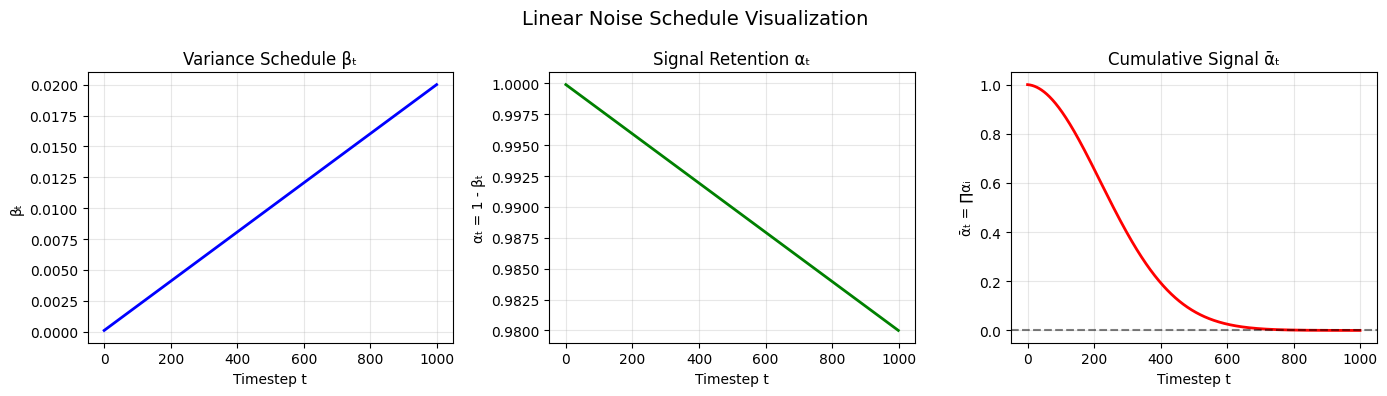


Interpretation:
  At t=0:   ᾱ₀ ≈ 0.9999 (almost all signal)
  At t=500: ᾱ₅₀₀ ≈ 0.0778
  At t=999: ᾱ_T ≈ 0.000040 (almost all noise)


In [29]:
# Visualize the noise schedule
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

timesteps = np.arange(T)

# Plot βₜ
axes[0].plot(timesteps, schedule.betas.cpu().numpy(), 'b-', linewidth=2)
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('βₜ')
axes[0].set_title('Variance Schedule βₜ')
axes[0].grid(True, alpha=0.3)

# Plot αₜ
axes[1].plot(timesteps, schedule.alphas.cpu().numpy(), 'g-', linewidth=2)
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('αₜ = 1 - βₜ')
axes[1].set_title('Signal Retention αₜ')
axes[1].grid(True, alpha=0.3)

# Plot ᾱₜ (cumulative product)
axes[2].plot(timesteps, schedule.alphas_cumprod.cpu().numpy(), 'r-', linewidth=2)
axes[2].set_xlabel('Timestep t')
axes[2].set_ylabel('ᾱₜ = ∏αᵢ')
axes[2].set_title('Cumulative Signal ᾱₜ')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.suptitle('Linear Noise Schedule Visualization', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"  At t=0:   ᾱ₀ ≈ {schedule.alphas_cumprod[0]:.4f} (almost all signal)")
print(f"  At t=500: ᾱ₅₀₀ ≈ {schedule.alphas_cumprod[500]:.4f}")
print(f"  At t=999: ᾱ_T ≈ {schedule.alphas_cumprod[-1]:.6f} (almost all noise)")

### Part 2: Forward Diffusion Process

<span style="font-size: 15px;">

The forward process adds noise to images according to the schedule. The key formula allows us to **jump directly** from $x_0$ to any $x_t$:

$$
\boxed{x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon}
$$

where $\epsilon \sim \mathcal{N}(0, I)$ is pure Gaussian noise.

**Intuition:**
- $\sqrt{\bar{\alpha}_t} \cdot x_0$: The "signal" part (shrinks as $t$ increases)
- $\sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$: The "noise" part (grows as $t$ increases)
- At $t = T$: $\bar{\alpha}_T \approx 0$, so $x_T \approx \epsilon$ (pure noise)

**Why this formula?** This closed-form solution comes from the fact that adding Gaussian noise repeatedly is equivalent to adding one larger Gaussian noise. The coefficients ensure the variance stays normalized.

</span>

In [30]:
def forward_diffusion(x_0, t, schedule):
    """
    Forward diffusion: Add noise to images.
    
    Implements: xₜ = √ᾱₜ · x₀ + √(1-ᾱₜ) · ε
    
    Args:
        x_0: Clean images, shape (B, C, H, W)
        t: Timesteps, shape (B,)
        schedule: NoiseSchedule object
    
    Returns:
        x_t: Noisy images at timestep t
        noise: The noise that was added (needed for training)
    """
    # Sample noise ε ~ N(0, I)
    noise = torch.randn_like(x_0)
    
    # Get √ᾱₜ for each sample in batch
    sqrt_alphas_cumprod_t = schedule.get_index_from_list(
        schedule.sqrt_alphas_cumprod, t, x_0.shape
    )
    
    # Get √(1-ᾱₜ) for each sample in batch
    sqrt_one_minus_alphas_cumprod_t = schedule.get_index_from_list(
        schedule.sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    # Apply forward diffusion formula
    # xₜ = √ᾱₜ · x₀ + √(1-ᾱₜ) · ε
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    
    return x_t, noise

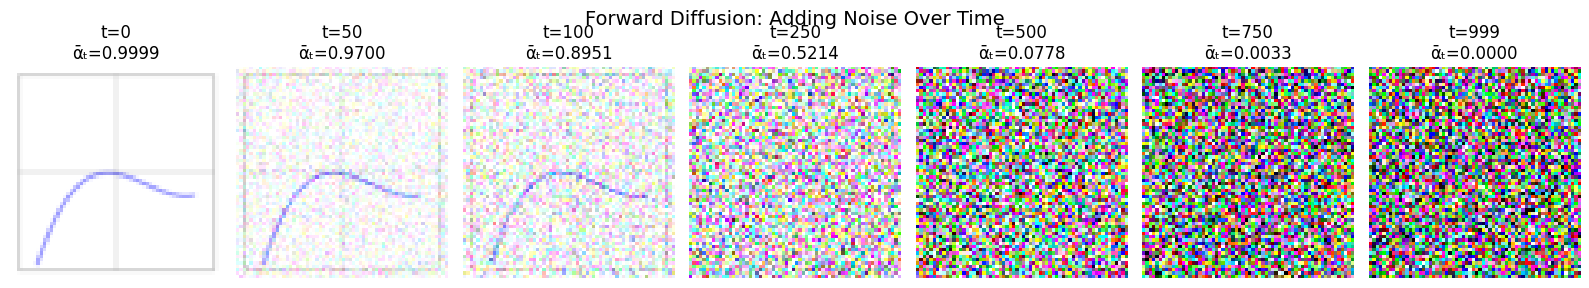


Observe: As t increases, the image becomes progressively noisier.
At t=999, the image is almost pure Gaussian noise.


In [31]:
# Visualize the forward diffusion process
# Show how a clean image gets progressively noisier

sample_image = dataset[0].unsqueeze(0).to(device)  # Shape: (1, C, H, W)

# Timesteps to visualize
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(16, 3))

for i, t_val in enumerate(timesteps_to_show):
    t = torch.tensor([t_val], device=device)
    
    if t_val == 0:
        # At t=0, show original (no noise added)
        noisy_img = sample_image
    else:
        noisy_img, _ = forward_diffusion(sample_image, t, schedule)
    
    axes[i].imshow(tensor_to_image(noisy_img))
    alpha_bar = schedule.alphas_cumprod[t_val].item()
    axes[i].set_title(f't={t_val}\nᾱₜ={alpha_bar:.4f}')
    axes[i].axis('off')

plt.suptitle('Forward Diffusion: Adding Noise Over Time', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObserve: As t increases, the image becomes progressively noisier.")
print("At t=999, the image is almost pure Gaussian noise.")

### Part 3: The U-Net Architecture

<span style="font-size: 15px;">

The neural network $\epsilon_\theta(x_t, t)$ takes a noisy image $x_t$ and the timestep $t$, and predicts the noise $\epsilon$ that was added.

**Why U-Net?**
- **Encoder-Decoder Structure**: Captures both local details and global context
- **Skip Connections**: Preserve fine-grained spatial information
- **Same Input/Output Size**: Input and output have the same dimensions

**Key Components:**

| Component | Purpose |
|-----------|--------|
| **Time Embedding** | Encode timestep $t$ into a vector the network can use |
| **Encoder (Downsampling)** | Extract features at multiple scales |
| **Middle Block** | Process at lowest resolution |
| **Decoder (Upsampling)** | Reconstruct spatial dimensions |
| **Skip Connections** | Connect encoder to decoder at matching resolutions |

**Time Embedding**: We use sinusoidal embeddings (like in Transformers) to encode the timestep:

$$
\text{PE}(t, 2i) = \sin\left(\frac{t}{10000^{2i/d}}\right), \quad \text{PE}(t, 2i+1) = \cos\left(\frac{t}{10000^{2i/d}}\right)
$$

</span>

In [32]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal embeddings for timestep encoding.
    
    Converts integer timesteps into continuous vector representations
    that the network can use to condition its predictions.
    """
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        """
        Args:
            t: Timesteps, shape (B,)
        
        Returns:
            Embeddings, shape (B, dim)
        """
        device = t.device
        half_dim = self.dim // 2
        
        # Compute frequencies
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        
        # Outer product: (B,) x (half_dim,) -> (B, half_dim)
        embeddings = t[:, None] * embeddings[None, :]
        
        # Concatenate sin and cos
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        
        return embeddings

In [33]:
class ConvBlock(nn.Module):
    """
    Basic convolutional block with normalization and activation.
    
    Structure: Conv -> GroupNorm -> SiLU -> Conv -> GroupNorm -> SiLU
    """
    
    def __init__(self, in_channels, out_channels, time_emb_dim=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.activation = nn.SiLU()  # Swish activation
        
        # Time embedding projection (if provided)
        if time_emb_dim is not None:
            self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        else:
            self.time_mlp = None
    
    def forward(self, x, t_emb=None):
        """
        Args:
            x: Input tensor, shape (B, C, H, W)
            t_emb: Time embedding, shape (B, time_emb_dim)
        """
        h = self.activation(self.norm1(self.conv1(x)))
        
        # Add time embedding
        if self.time_mlp is not None and t_emb is not None:
            time_emb = self.activation(self.time_mlp(t_emb))
            h = h + time_emb[:, :, None, None]  # Broadcast to spatial dims
        
        h = self.activation(self.norm2(self.conv2(h)))
        return h

In [34]:
class SimpleUNet(nn.Module):
    """
    Simplified U-Net for noise prediction in diffusion models.
    
    Architecture:
        Encoder: 64 -> 128 -> 256 (with downsampling)
        Middle: 256 -> 256
        Decoder: 256 -> 128 -> 64 (with upsampling + skip connections)
        Output: 64 -> 3 (predicting noise with same shape as input)
    
    The network takes:
        - x_t: Noisy image at timestep t
        - t: The timestep (encoded via sinusoidal embeddings)
    
    And outputs:
        - ε_pred: Predicted noise
    """
    
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=128):
        super().__init__()
        
        self.time_emb_dim = time_emb_dim
        
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
        )
        
        # Encoder (Downsampling path)
        self.enc1 = ConvBlock(in_channels, 64, time_emb_dim)     # 64x64 -> 64x64
        self.pool1 = nn.MaxPool2d(2)                              # 64x64 -> 32x32
        
        self.enc2 = ConvBlock(64, 128, time_emb_dim)             # 32x32 -> 32x32
        self.pool2 = nn.MaxPool2d(2)                              # 32x32 -> 16x16
        
        self.enc3 = ConvBlock(128, 256, time_emb_dim)            # 16x16 -> 16x16
        self.pool3 = nn.MaxPool2d(2)                              # 16x16 -> 8x8
        
        # Middle (Bottleneck)
        self.middle = ConvBlock(256, 256, time_emb_dim)          # 8x8 -> 8x8
        
        # Decoder (Upsampling path)
        self.up3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)  # 8x8 -> 16x16
        self.dec3 = ConvBlock(512, 128, time_emb_dim)  # 256 + 256 skip = 512
        
        self.up2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 16x16 -> 32x32
        self.dec2 = ConvBlock(256, 64, time_emb_dim)   # 128 + 128 skip = 256
        
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # 32x32 -> 64x64
        self.dec1 = ConvBlock(128, 64, time_emb_dim)   # 64 + 64 skip = 128
        
        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x, t):
        """
        Args:
            x: Noisy image x_t, shape (B, C, H, W)
            t: Timesteps, shape (B,)
        
        Returns:
            Predicted noise ε_θ(x_t, t), shape (B, C, H, W)
        """
        # Embed timestep
        t_emb = self.time_embed(t.float())  # (B, time_emb_dim)
        
        # Encoder
        e1 = self.enc1(x, t_emb)           # 64x64, 64 channels
        e2 = self.enc2(self.pool1(e1), t_emb)  # 32x32, 128 channels
        e3 = self.enc3(self.pool2(e2), t_emb)  # 16x16, 256 channels
        
        # Middle
        m = self.middle(self.pool3(e3), t_emb)  # 8x8, 256 channels
        
        # Decoder with skip connections
        d3 = self.up3(m)                   # 16x16, 256 channels
        d3 = torch.cat([d3, e3], dim=1)    # 16x16, 512 channels (skip connection)
        d3 = self.dec3(d3, t_emb)          # 16x16, 128 channels
        
        d2 = self.up2(d3)                  # 32x32, 128 channels
        d2 = torch.cat([d2, e2], dim=1)    # 32x32, 256 channels (skip connection)
        d2 = self.dec2(d2, t_emb)          # 32x32, 64 channels
        
        d1 = self.up1(d2)                  # 64x64, 64 channels
        d1 = torch.cat([d1, e1], dim=1)    # 64x64, 128 channels (skip connection)
        d1 = self.dec1(d1, t_emb)          # 64x64, 64 channels
        
        # Output: predict noise
        return self.out(d1)                # 64x64, 3 channels

In [35]:
# Create the model and inspect it
model = SimpleUNet(in_channels=3, out_channels=3, time_emb_dim=128).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {n_params:,} trainable parameters")

# Test forward pass
test_input = torch.randn(2, 3, 64, 64, device=device)
test_t = torch.randint(0, T, (2,), device=device)
test_output = model(test_input, test_t)

print(f"\nTest forward pass:")
print(f"  Input shape:  {test_input.shape}")
print(f"  Timesteps:    {test_t.tolist()}")
print(f"  Output shape: {test_output.shape}")
print(f"\n✓ Model is working correctly!")

Model created with 3,847,171 trainable parameters

Test forward pass:
  Input shape:  torch.Size([2, 3, 64, 64])
  Timesteps:    [53, 787]
  Output shape: torch.Size([2, 3, 64, 64])

✓ Model is working correctly!


### Part 4: Training the Diffusion Model

<span style="font-size: 15px;">

Now we implement the training loop. The goal is to train the network to predict the noise that was added to an image.

**Training Algorithm:**

```
Repeat until convergence:
  1. Sample batch: {x₀⁽¹⁾, ..., x₀⁽ᴮ⁾} from dataset
  2. Sample random timesteps: t⁽ⁱ⁾ ~ Uniform({1, ..., T}) for each i
  3. Sample noise: ε⁽ⁱ⁾ ~ N(0, I) for each i
  4. Create noisy images: xₜ⁽ⁱ⁾ = √ᾱₜ · x₀⁽ⁱ⁾ + √(1-ᾱₜ) · ε⁽ⁱ⁾
  5. Predict noise: ε_pred⁽ⁱ⁾ = ε_θ(xₜ⁽ⁱ⁾, t⁽ⁱ⁾)
  6. Compute loss: L = (1/B) · Σᵢ ‖ε⁽ⁱ⁾ - ε_pred⁽ⁱ⁾‖²
  7. Update parameters: θ ← θ - η∇_θL
```

**Key Points:**
- We sample **random timesteps** for each image in the batch
- We jump **directly** from $x_0$ to $x_t$ (no iterative noising)
- The loss is simply **MSE between true noise and predicted noise**

**Loss Function:**
$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

</span>

In [36]:
def train_step(model, x_0, schedule, optimizer):
    """
    Perform one training step.
    
    Args:
        model: The U-Net model
        x_0: Batch of clean images, shape (B, C, H, W)
        schedule: NoiseSchedule object
        optimizer: PyTorch optimizer
    
    Returns:
        loss: The training loss value
    """
    optimizer.zero_grad()
    
    batch_size = x_0.shape[0]
    
    # Step 2: Sample random timesteps t ~ Uniform({0, 1, ..., T-1})
    t = torch.randint(0, schedule.T, (batch_size,), device=x_0.device)
    
    # Steps 3-4: Add noise (forward diffusion)
    # This samples ε ~ N(0,I) and computes xₜ = √ᾱₜ · x₀ + √(1-ᾱₜ) · ε
    x_t, noise = forward_diffusion(x_0, t, schedule)
    
    # Step 5: Predict the noise
    noise_pred = model(x_t, t)
    
    # Step 6: Compute MSE loss
    loss = F.mse_loss(noise_pred, noise)
    
    # Step 7: Backprop and update
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [57]:
def train_diffusion_model(model, dataloader, schedule, epochs=100, lr=1e-3):
    """
    Train the diffusion model.
    
    Args:
        model: The U-Net model
        dataloader: DataLoader with training images
        schedule: NoiseSchedule object
        epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        losses: List of average losses per epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    print(f"Training for {epochs} epochs...")
    print("=" * 50)
    
    for epoch in range(epochs):
        epoch_losses = []
        
        for batch in dataloader:
            x_0 = batch.to(device)
            loss = train_step(model, x_0, schedule, optimizer)
            epoch_losses.append(loss)
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.6f}")
    
    print("=" * 50)
    print("Training complete!")
    
    return losses

In [65]:
# Train the model
# Note: For best results, train for more epochs (e.g., 200-500)
# Here we use fewer epochs for demonstration

EPOCHS = 1000  # Increase for better results
LEARNING_RATE = 1e-3

losses = train_diffusion_model(
    model=model,
    dataloader=dataloader,
    schedule=schedule,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

Training for 1000 epochs...
Epoch   1/1000 | Loss: 0.002621
Epoch  10/1000 | Loss: 0.001646
Epoch  20/1000 | Loss: 0.001544
Epoch  30/1000 | Loss: 0.001558
Epoch  40/1000 | Loss: 0.002979
Epoch  50/1000 | Loss: 0.001313
Epoch  60/1000 | Loss: 0.001797
Epoch  70/1000 | Loss: 0.001457
Epoch  80/1000 | Loss: 0.001376
Epoch  90/1000 | Loss: 0.001521
Epoch 100/1000 | Loss: 0.002602
Epoch 110/1000 | Loss: 0.001378
Epoch 120/1000 | Loss: 0.002414
Epoch 130/1000 | Loss: 0.004266
Epoch 140/1000 | Loss: 0.002768
Epoch 150/1000 | Loss: 0.001300
Epoch 160/1000 | Loss: 0.001111
Epoch 170/1000 | Loss: 0.001486
Epoch 180/1000 | Loss: 0.001107
Epoch 190/1000 | Loss: 0.001456
Epoch 200/1000 | Loss: 0.001853
Epoch 210/1000 | Loss: 0.001385
Epoch 220/1000 | Loss: 0.001072
Epoch 230/1000 | Loss: 0.001113
Epoch 240/1000 | Loss: 0.001129
Epoch 250/1000 | Loss: 0.002814
Epoch 260/1000 | Loss: 0.001148
Epoch 270/1000 | Loss: 0.001856
Epoch 280/1000 | Loss: 0.001092
Epoch 290/1000 | Loss: 0.002093
Epoch 300/10

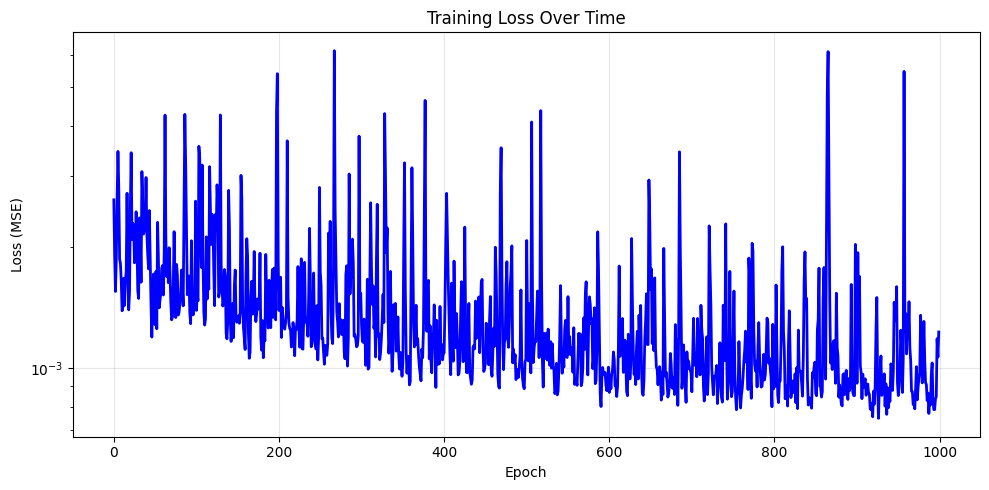

Final loss: 0.001229


In [66]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to see early progress
plt.tight_layout()
plt.show()

print(f"Final loss: {losses[-1]:.6f}")

### Part 5: Sampling (Generating New Images)

<span style="font-size: 15px;">

Now comes the exciting part: **generating new images from pure noise!**

The sampling algorithm is the **reverse** of the forward process. Starting from pure Gaussian noise $x_T \sim \mathcal{N}(0, I)$, we iteratively denoise step by step.

**Sampling Algorithm:**

```
1. Initialize: x_T ~ N(0, I)   (pure noise)

2. For t = T, T-1, ..., 2, 1:
    a. Predict noise: ε_pred = ε_θ(xₜ, t)
    
    b. Compute mean:
       μₜ = (1/√αₜ) · (xₜ - ((1-αₜ)/√(1-ᾱₜ)) · ε_pred)
    
    c. Add noise (except at t=1):
       if t > 1:
           z ~ N(0, I)
           xₜ₋₁ = μₜ + √βₜ · z
       else:
           x₀ = μₜ  (no noise at final step)

3. Return x₀
```

**Key Formula for Computing the Mean:**

$$
\mu_t = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \epsilon_\theta(x_t, t) \right)
$$

**Important Differences from Training:**

| Training | Sampling |
|----------|----------|
| Random timesteps | Sequential T → 1 |
| Parameters updated | Parameters frozen |
| 1 forward pass per batch | T forward passes per image |
| Jump $x_0 \to x_t$ | Iterate $x_T \to x_{T-1} \to \cdots \to x_0$ |

</span>

In [67]:
@torch.no_grad()
def sample(model, schedule, n_samples=1, img_size=64, channels=3):
    """
    Generate new images by sampling from the learned distribution.
    
    Implements the reverse diffusion process:
        x_T -> x_{T-1} -> ... -> x_1 -> x_0
    
    Args:
        model: Trained U-Net model (parameters frozen)
        schedule: NoiseSchedule object
        n_samples: Number of images to generate
        img_size: Size of generated images
        channels: Number of image channels
    
    Returns:
        x_0: Generated images, shape (n_samples, C, H, W)
    """
    model.eval()  # Set to evaluation mode
    
    # Step 1: Initialize with pure noise x_T ~ N(0, I)
    x = torch.randn(n_samples, channels, img_size, img_size, device=device)
    
    # Step 2: Iterate from t=T-1 down to t=0
    for t in tqdm(reversed(range(schedule.T)), desc='Sampling', total=schedule.T):
        # Create batch of timesteps
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise ε_θ(xₜ, t)
        noise_pred = model(x, t_batch)
        
        # Get schedule values for timestep t
        alpha_t = schedule.alphas[t]
        alpha_bar_t = schedule.alphas_cumprod[t]
        beta_t = schedule.betas[t]
        
        # Compute mean μₜ
        # μₜ = (1/√αₜ) · (xₜ - ((1-αₜ)/√(1-ᾱₜ)) · ε_pred)
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)
        mu = coef1 * (x - coef2 * noise_pred)
        
        # Add noise (except at t=0)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)
            x = mu + sigma * noise
        else:
            x = mu  # Final step: no noise
    
    model.train()  # Set back to training mode
    return x

Generating new polynomial plots from pure noise...
This may take a moment as we iterate through all timesteps.



Sampling: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.68it/s]


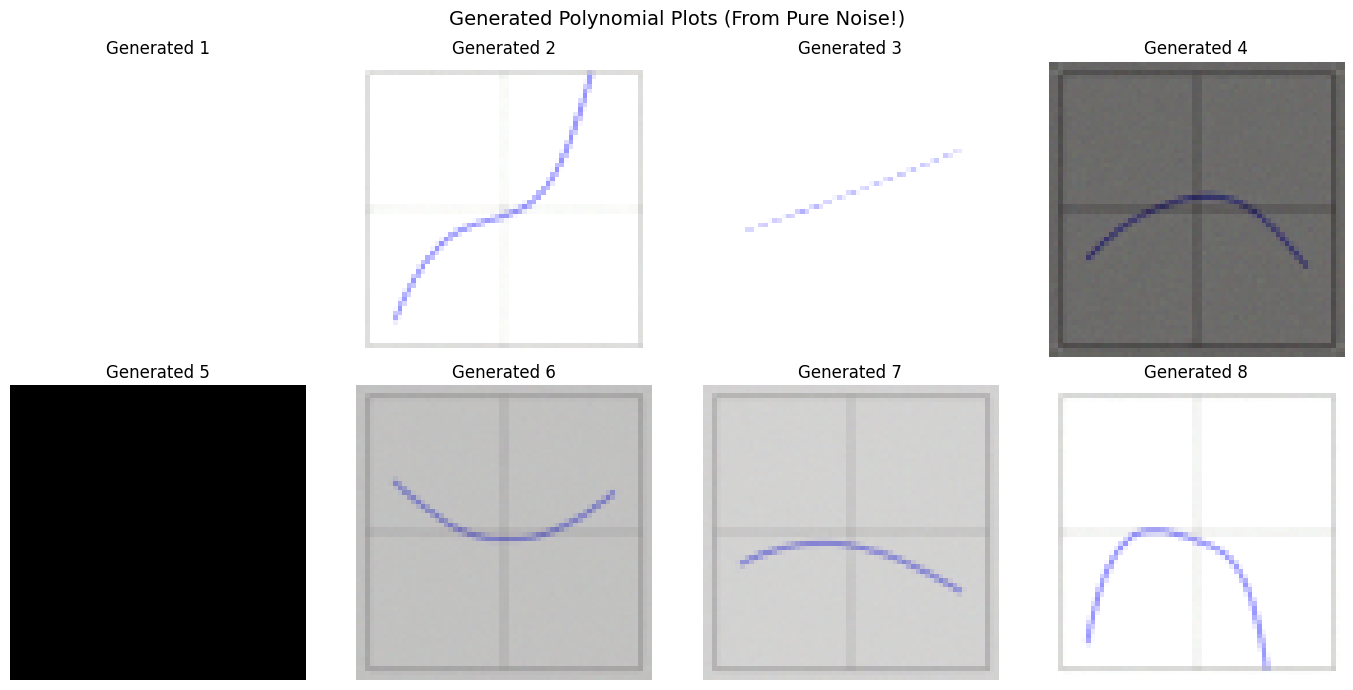

In [68]:
# Generate new polynomial plot images!
print("Generating new polynomial plots from pure noise...")
print("This may take a moment as we iterate through all timesteps.\n")

n_samples = 8
generated_images = sample(model, schedule, n_samples=n_samples, img_size=IMAGE_SIZE)

# Display generated images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(tensor_to_image(generated_images[i]))
    ax.set_title(f'Generated {i+1}')
    ax.axis('off')

plt.suptitle('Generated Polynomial Plots (From Pure Noise!)', fontsize=14)
plt.tight_layout()
plt.show()

### Visualizing the Denoising Process

<span style="font-size: 15px;">

Let's visualize how an image emerges from pure noise during the sampling process.

</span>

In [69]:
@torch.no_grad()
def sample_with_trajectory(model, schedule, img_size=64, channels=3, save_every=100):
    """
    Sample one image and save intermediate steps for visualization.
    
    Returns:
        trajectory: List of (timestep, image) tuples
    """
    model.eval()
    
    trajectory = []
    x = torch.randn(1, channels, img_size, img_size, device=device)
    
    # Save initial noise
    trajectory.append((schedule.T, x.clone()))
    
    for t in reversed(range(schedule.T)):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        
        alpha_t = schedule.alphas[t]
        alpha_bar_t = schedule.alphas_cumprod[t]
        beta_t = schedule.betas[t]
        
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)
        mu = coef1 * (x - coef2 * noise_pred)
        
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)
            x = mu + sigma * noise
        else:
            x = mu
        
        # Save intermediate steps
        if t % save_every == 0 or t == 0:
            trajectory.append((t, x.clone()))
    
    model.train()
    return trajectory

Sampling with trajectory visualization...


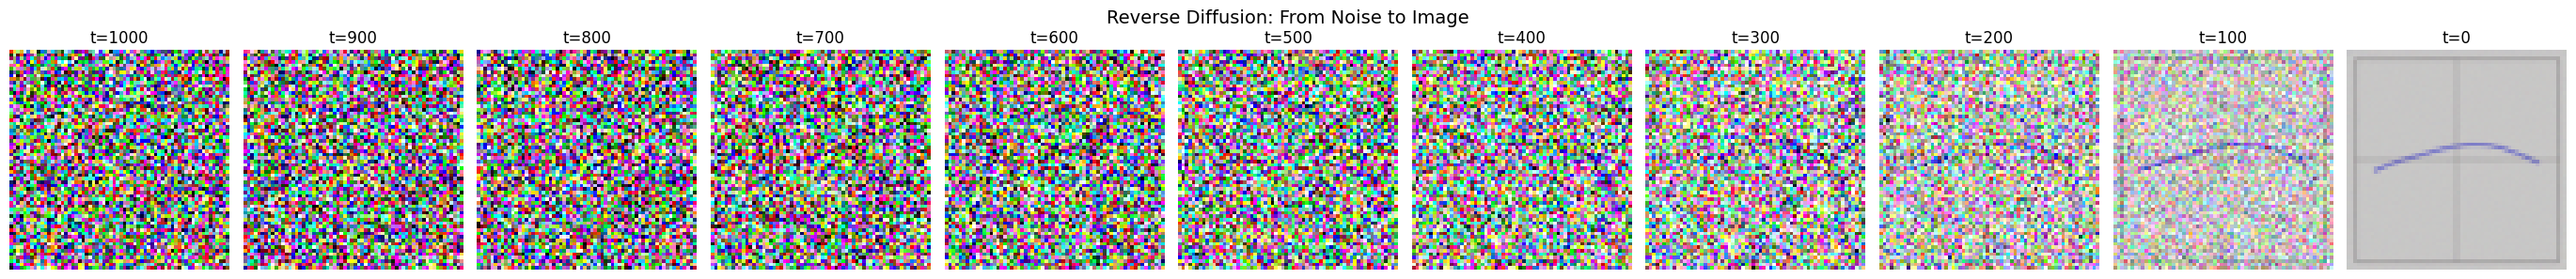


Observe how the image gradually emerges from pure noise!
Early steps establish rough structure, later steps refine details.


In [73]:
# Generate and visualize the denoising trajectory
print("Sampling with trajectory visualization...")
trajectory = sample_with_trajectory(model, schedule, img_size=IMAGE_SIZE, save_every=100)

# Plot the trajectory
n_steps = len(trajectory)
fig, axes = plt.subplots(1, n_steps, figsize=(2.5 * n_steps, 3))

for i, (t, img) in enumerate(trajectory):
    axes[i].imshow(tensor_to_image(img))
    axes[i].set_title(f't={t}')
    axes[i].axis('off')

plt.suptitle('Reverse Diffusion: From Noise to Image', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObserve how the image gradually emerges from pure noise!")
print("Early steps establish rough structure, later steps refine details.")

### Comparing Real vs Generated Images

Generating samples for comparison...


Sampling: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.41it/s]


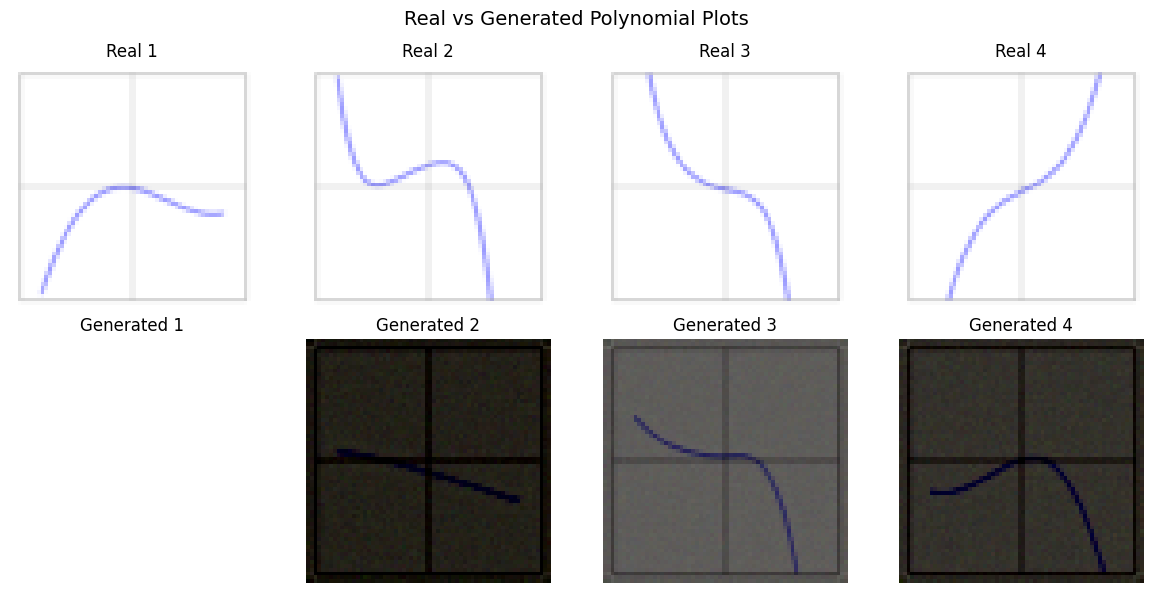

In [74]:
# Side-by-side comparison of real and generated images
n_compare = 4

# Get some real images
real_images = torch.stack([dataset[i] for i in range(n_compare)])

# Generate new images
print("Generating samples for comparison...")
generated = sample(model, schedule, n_samples=n_compare, img_size=IMAGE_SIZE)

# Plot comparison
fig, axes = plt.subplots(2, n_compare, figsize=(3 * n_compare, 6))

for i in range(n_compare):
    # Real images (top row)
    axes[0, i].imshow(tensor_to_image(real_images[i]))
    axes[0, i].set_title(f'Real {i+1}')
    axes[0, i].axis('off')
    
    # Generated images (bottom row)
    axes[1, i].imshow(tensor_to_image(generated[i]))
    axes[1, i].set_title(f'Generated {i+1}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Real', fontsize=12)
axes[1, 0].set_ylabel('Generated', fontsize=12)

plt.suptitle('Real vs Generated Polynomial Plots', fontsize=14)
plt.tight_layout()
plt.show()

## Section 4: Summary

<span style="font-size: 15px;">

**What We Built:**

| Component | Implementation |
|-----------|---------------|
| **Noise Schedule** | Linear schedule $\beta_t$ from 0.0001 to 0.02 over 1000 steps |
| **Forward Process** | $x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1-\bar{\alpha}_t} \cdot \epsilon$ |
| **U-Net** | Encoder-decoder with skip connections and time embeddings |
| **Training** | MSE loss: $\mathcal{L} = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$ |
| **Sampling** | Iterative denoising from $x_T$ to $x_0$ |



**Key Insights:**

1. **Training is simple**: Just predict the noise that was added
2. **Random timesteps during training**: Each batch sees different noise levels
3. **Sequential timesteps during sampling**: Must iterate through all $T$ steps, starting from $T$ and going back to $t = 0$.
4. **The network learns**: What noise looks like at different stages of corruption

---
**Understanding the Oscillating Loss**

During training, we observed that the loss oscillates rather than decreasing smoothly:
```
Epoch 760/1000 | Loss: 0.000795
Epoch 770/1000 | Loss: 0.001877  ← Spike!
Epoch 780/1000 | Loss: 0.000896
...
Epoch 900/1000 | Loss: 0.001616  ← Spike!
Epoch 920/1000 | Loss: 0.000756
```

**Why does this happen?** The oscillation stems from three key factors:

| Factor | Explanation |
|--------|-------------|
| **Random timestep sampling** | Each batch samples random $t \sim \text{Uniform}(1, T)$. Some batches may contain mostly "easy" timesteps (low noise), others mostly "hard" timesteps (high noise), causing variance in loss. |
| **Small batch size** | With only 16 images per batch and 31 batches per epoch, the epoch-averaged loss is computed over relatively few samples, amplifying stochastic fluctuations. |
| **High learning rate** | A learning rate of $\eta = 10^{-3}$ can cause the optimizer to "overshoot" optimal points, leading to oscillation around the minimum rather than smooth convergence. |

**The Math Behind the Variance:**

The training loss at each step depends on the sampled timestep $t$. For high $t$ (images mostly noise), predicting $\epsilon$ is harder. For low $t$ (images mostly signal), it's easier:

$$\text{Var}[\mathcal{L}] \propto \text{Var}[t] + \text{Var}[\epsilon] + \frac{1}{B}\sigma^2$$

where $B$ is the batch size. Smaller $B$ means higher variance in the loss estimate.

**How to Reduce Oscillation:**

| Improvement | Implementation | Effect |
|-------------|----------------|--------|
| **Lower learning rate** | `lr=1e-4` or `lr=3e-4` | Smoother convergence, less overshooting |
| **Learning rate scheduler** | `CosineAnnealingLR` or `ReduceLROnPlateau` | Gradually reduce LR as training progresses |
| **Larger batch size** | `batch_size=32` or `64` | Lower variance in loss estimates |
| **EMA (Exponential Moving Average)** | Track moving average of model weights | More stable final model |
| **Gradient clipping** | `torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)` | Prevent large gradient spikes |

**Example: Adding a Learning Rate Scheduler**
```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in range(EPOCHS):
    # ... training loop ...
    scheduler.step()  # Decay learning rate
```

**Important Insight**: Despite the oscillation, the model *is* learning! The loss fluctuates around $\approx 0.001$, which is much lower than the initial loss of $\approx 0.02$. The oscillation represents noise in the loss estimate, not instability in learning. The generated images confirm the model has learned the data distribution.

---

**Training vs Sampling Comparison:**

| Aspect | Training | Sampling |
|--------|----------|----------|
| Direction | $x_0 \to x_t$ | $x_T \to x_0$ |
| Timesteps | Random $t$ | Sequential $T \to 1$ |
| Parameters | Updated (learning) | Frozen (inference) |
| Backprop | Yes | No |
| Forward passes | 1 per batch | $T$ per image |

---

**Key Takeaways:**

1. **Loss oscillation is normal** in diffusion model training due to random timestep sampling
2. **Lower learning rates** and **schedulers** help smooth convergence
3. **The model learns despite oscillation** — what matters is the overall trend and final sample quality
4. **Epoch-averaged loss** with small batches has high variance; consider tracking a moving average for clearer progress visualization

**Next Steps for Improvement:**
- Use a learning rate scheduler (cosine annealing works well)
- Increase batch size if memory permits
- Try different noise schedules (cosine) instead of linear
- Add EMA for more stable sampling
- Implement gradient clipping for training stability
- Train for more epochs for better quality
- Add attention layers for better long-range dependencies
- Experiment with classifier-free guidance for conditional generation

</span>

### Quick Reference

| Concept | Formula / Code |
|---------|----------------|
| Forward process | $x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1-\bar{\alpha}_t} \cdot \epsilon$ |
| Training loss | $\mathcal{L} = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$ |
| Reverse mean | $\mu_t = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta\right)$ |
| Reverse step | $x_{t-1} = \mu_t + \sqrt{\beta_t} \cdot z$ |
| Sample noise | `x_T = torch.randn(...)` |
| Time embedding | Sinusoidal positional encoding |